## Рекомендательные системы - 1

* Kaggle API
* Baseline: самые популярные товары
* Коллаборативная фильтрация
* Модели со скрытыми переменными

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import math

from tqdm import tqdm_notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себя логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

**Но сначала разберемся с удобным для дальнейших участий и просто скачивания данных инструментом, а именно api kaggle**

0. Скачиваем kaggle

In [2]:
! pip install --user kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 1.3 MB/s eta 0:00:0031m963.9 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.0 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.6-py3-none-any.whl size=111945 sha256=92f816f27166763916f3f4c5a53de4b7732ab335a5cd19ca4adb69cf0de49342
  Stored in directory: /Users/aarysmyatova/Library/Caches/pip/wheels/97/06/54/3d44857e6aa73d66d0174f29389e7ea70c007105797e6ec05c
Successfully built kaggle
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


1. Переходим в ваш аккаунт kaggle и там же ищем вкладку account
2. Ищем вот такое место внизу этой вкладки: 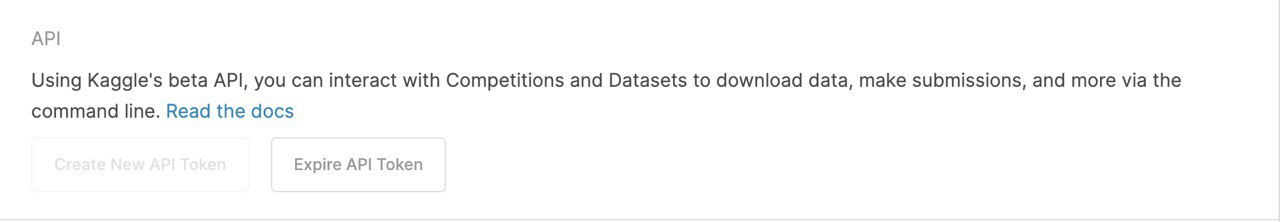 
И тут нажимаем create new api token

3. У вас скачивается файл с названием kaggle.json (обратите внимание чтобы было именно такое название, без (1) и т.д.)

4. Запускаем ниже код и выбираем вставить ваш скачанный json

In [17]:
# import google
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

5. Проверяем, что все работает, например, можем посмотреть какие соревнования на kaggle есть

In [3]:
!pip install --user kaggle


In [6]:
! /Users/aarysmyatova/.local/bin/kaggle competitions list

ref                                                                              deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-prompt-recovery                          2024-04-16 23:59:00  Featured          $200,000        722           False  
https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data  2024-04-23 23:59:00  Featured           $60,000       1368           False  
https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification    2024-04-08 23:59:00  Research           $50,000       2182           False  
https://www.kaggle.com/competitions/march-machine-learning-mania-2024            2024-04-10 23:59:00  Featured           $50,000        287           False  
https://www.kaggle.com/competitions/data-assistants-

Ура! Теперь мы научились этим пользоваться. Также через этот инстумент можно кидать submit файлы на скор, скачивать данные без посредников. Сейчас попробуем так сделать и скачаем данные для нашей домашней работы без хитрых выкачиваний на диски или (не дай бог) на локальную машину https://www.kaggle.com/docs/api

In [7]:
! /Users/aarysmyatova/.local/bin/kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop

 85%|████████████████████████████████▍     | 7.00M/8.20M [00:00<00:00, 11.7MB/s]
100%|██████████████████████████████████████| 8.20M/8.20M [00:00<00:00, 9.33MB/s]


In [8]:
! unzip articles-sharing-reading-from-cit-deskdrop.zip

Archive:  articles-sharing-reading-from-cit-deskdrop.zip
  inflating: shared_articles.csv     
  inflating: users_interactions.csv  


**Ура, мы можем работать!**

Мы загрузили Deskdrop dataset, включающий в себя логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [81]:
articles_df = pd.read_csv('shared_articles.csv')

In [82]:
articles_df

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,1487946604,CONTENT SHARED,9213260650272029784,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt
3118,1487947067,CONTENT SHARED,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en
3119,1488223224,CONTENT SHARED,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en
3120,1488300719,CONTENT SHARED,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en


In [83]:
articles_df.eventType.value_counts()

eventType
CONTENT SHARED     3047
CONTENT REMOVED      75
Name: count, dtype: int64

In [84]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [85]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
72307,1485190425,LIKE,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72308,1485190425,VIEW,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
72309,1485190072,VIEW,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR
72310,1485190434,VIEW,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR


In [86]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/1305389506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df.contentId = articles_df.contentId.astype(str)


### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [87]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [88]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [89]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


<Axes: >

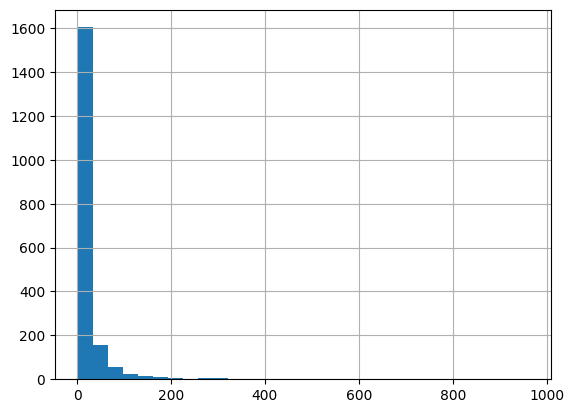

In [90]:
users_interactions_count_df.hist(bins=30)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [91]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [92]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделения выборки на обучение и контроль.

In [93]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
...,...,...,...,...
39101,998688566268269815,-401664538366009049,1.000000,1474567449
39102,998688566268269815,3456674717452933449,2.584963,1478802088
39103,998688566268269815,6881796783400625893,1.000000,1474567675
39104,998688566268269815,7174452660053929140,2.321928,1478812905


Разобьём выборку на обучение и контроль по времени.

In [94]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.25,
                                   random_state=42)

```
Как повлияет такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [95]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы. 

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности.

In [96]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [97]:
print(articles_df.loc[articles_df.contentId == popular_content[1]]['title'].values)

['Novo workaholic trabalha, pratica esportes e tem tempo para a família. Conheça']


In [98]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [99]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

interactions['prediction_popular'][0]

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/709329523.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interactions['prediction_popular'][0]


array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

In [101]:
interactions

,true_train,true_test,prediction_popular
personId,,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72...","[-6783772548752091658, -133139342397538859, -8..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -...","[-6783772548752091658, -133139342397538859, -8..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -...","[-6783772548752091658, -8208801367848627943, 8..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -...","[-133139342397538859, -8208801367848627943, 82..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224],"[-6783772548752091658, -8208801367848627943, 8..."
...,...,...,...
953707509720613429,"[-1068603220639552685, -2358756719610361882, -...","[-2402288292108892893, -5813211845057621660, -...","[-133139342397538859, -8208801367848627943, 82..."
983095443598229476,"[-133139342397538859, -8742648016180281673]","[-14569272361926584, -1572252285162838958, -18...","[-6783772548752091658, -8208801367848627943, 8..."
989049974880576288,"[-133139342397538859, -2038869595290705317, -2...","[-6289909056857931861, -7047448754687279385, -...","[-6783772548752091658, -8208801367848627943, 8..."


In [100]:
interactions['prediction_popular'][1]

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/482713353.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interactions['prediction_popular'][1]


array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '7507067965574797372',
       '-2358756719610361882', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336',
       '2581138407738454418', '-1633984990770981161'], dtype=object)

Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

In [102]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [103]:
calc_precision('prediction_popular')

0.006454207722621089

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [104]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [105]:
ratings

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
-1032019229384696495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0
-108842214936804958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,0.0,0.0
-1130272294246983140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
-1160159014793528221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953707509720613429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
983095443598229476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
989049974880576288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Memory-based

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [106]:
ratings_m = ratings.values

In [107]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue

        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/3330489667.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings_m)-1)):


  0%|          | 0/1111 [00:00<?, ?it/s]

In [108]:
ratings_v

array([5.4918531, 1.5849625])

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитаем качество по той же метрике.

In [109]:
np.array([1,2,3][::-1])

array([3, 2, 1])

In [110]:
?np.in1d

In [111]:
interactions

,true_train,true_test,prediction_popular
personId,,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72...","[-6783772548752091658, -133139342397538859, -8..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -...","[-6783772548752091658, -133139342397538859, -8..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -...","[-6783772548752091658, -8208801367848627943, 8..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -...","[-133139342397538859, -8208801367848627943, 82..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224],"[-6783772548752091658, -8208801367848627943, 8..."
...,...,...,...
953707509720613429,"[-1068603220639552685, -2358756719610361882, -...","[-2402288292108892893, -5813211845057621660, -...","[-133139342397538859, -8208801367848627943, 82..."
983095443598229476,"[-133139342397538859, -8742648016180281673]","[-14569272361926584, -1572252285162838958, -18...","[-6783772548752091658, -8208801367848627943, 8..."
989049974880576288,"[-133139342397538859, -2038869595290705317, -2...","[-6289909056857931861, -7047448754687279385, -...","[-6783772548752091658, -8208801367848627943, 8..."


In [112]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):

    users_sim = similarity_users[i] > 0
#     print(users_sim)
    if users_sim.sum() == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
#         print(ratings_m[users_sim].sum(axis=0).shape)
#         print(np.argsort(ratings_m[users_sim].sum(axis=0))[::-1])
#         print(ratings.columns[tmp_recommend])
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i]['true_train'])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/3503148429.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(similarity_users))):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [113]:
interactions

,true_train,true_test,prediction_popular,prediction_user_based
personId,,,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72...","[-6783772548752091658, -133139342397538859, -8...",[]
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -...","[-6783772548752091658, -133139342397538859, -8...","[-8208801367848627943, 8657408509986329668, -1..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -...","[-6783772548752091658, -8208801367848627943, 8...","[8657408509986329668, -8208801367848627943, -8..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -...","[-133139342397538859, -8208801367848627943, 82...","[2857117417189640073, 8657408509986329668, -82..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224],"[-6783772548752091658, -8208801367848627943, 8...","[8657408509986329668, 7544768317373280661, -68..."
...,...,...,...,...
953707509720613429,"[-1068603220639552685, -2358756719610361882, -...","[-2402288292108892893, -5813211845057621660, -...","[-133139342397538859, -8208801367848627943, 82...","[-133139342397538859, -5488842573681626972, 82..."
983095443598229476,"[-133139342397538859, -8742648016180281673]","[-14569272361926584, -1572252285162838958, -18...","[-6783772548752091658, -8208801367848627943, 8...","[-1297580205670251233, -4571929941432664145, -..."
989049974880576288,"[-133139342397538859, -2038869595290705317, -2...","[-6289909056857931861, -7047448754687279385, -...","[-6783772548752091658, -8208801367848627943, 8...","[-5148591903395022444, 8657408509986329668, -6..."


In [48]:
ratings_m.shape

(1112, 2366)

In [46]:
similarity_users

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.41742881, ..., -0.82922103,
         0.        ,  0.        ],
       [ 0.        ,  0.41742881,  0.        , ..., -1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.82922103, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [114]:
calc_precision('prediction_user_based')

0.0045585587099675725

### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

Заметим, что мы используем матрицу с нулями, будто отсутствующие взаимодействия негативные, что странно.

Если бы мы учили модель со скрытыми переменными с помощью стохастического градиентного спуска, то неизвестные взаимодействия могли бы не использовать.

In [115]:
from scipy.linalg import svd

In [116]:
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [117]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

2.0079717259469202e-24


In [77]:
new_rating

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,-0.003817,0.000868,-0.001242,0.002937,0.003939,0.013785,-0.001590,0.032580,-0.001280,0.000221,...,-0.003822,-0.000195,-0.008581,-0.000038,0.010840,0.009443,0.003429,-0.000165,0.009655,-0.002502
-1032019229384696495,0.992390,0.015841,0.029096,0.001692,0.012849,0.035017,1.013717,0.002997,0.010867,-0.004484,...,2.974765,0.007286,-0.020257,-0.004136,2.352017,-0.031010,0.032842,0.001878,-0.003590,0.009423
-108842214936804958,-0.016242,-0.029506,-0.036228,-0.011770,0.045758,0.016218,0.177273,0.014131,0.021399,-0.029963,...,0.134992,0.029008,-0.050164,-0.000008,-0.179158,-0.079576,1.891027,0.015783,0.003247,-0.017270
-1130272294246983140,0.167638,0.105631,0.226600,0.055745,-0.011829,-0.082997,0.004586,-0.069054,-0.039299,0.064394,...,0.042344,-0.055518,0.217676,-0.005865,1.142596,-0.176626,-0.020833,0.041321,-0.059519,0.017458
-1160159014793528221,0.011386,-0.002535,0.005586,-0.005096,-0.004767,-0.052055,-0.016270,-0.000096,0.019590,-0.003079,...,-0.004910,0.008653,-0.024729,0.002648,-0.007366,0.035675,0.003208,0.000350,-0.034150,0.003838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953707509720613429,-0.008502,0.008734,-0.032323,0.012374,-0.004362,-0.068585,-0.026149,-0.008802,-0.006793,0.010975,...,-0.008667,-0.023072,-0.067109,0.000776,0.158696,-0.019245,-0.008620,-0.001167,0.074981,0.004806
983095443598229476,-0.033527,-0.017540,0.005985,-0.024168,-0.079732,-0.018082,-0.058004,-0.020086,-0.005856,0.058689,...,0.020094,-0.011795,-0.049974,0.035262,-0.108349,0.087824,0.043763,0.010493,-0.078732,0.011249
989049974880576288,-0.012380,-0.017332,0.012745,-0.005520,-0.035221,0.094502,-0.045629,0.004162,-0.006897,0.050415,...,-0.000879,-0.052456,0.207664,0.032361,-0.205563,0.076851,0.040778,0.013628,0.180995,0.004999


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [124]:
K = 50

sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [125]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

38065.13280205778
78622.13000466056


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [126]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

/var/folders/s3/ydbs3hzj3kj1ybtxdgpw1q4w0000gn/T/ipykernel_13620/376199810.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [127]:
calc_precision('prediction_svd')

0.01278927865444892